In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,LSTM, Flatten, Dense, MaxPool2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras import Model, Input, regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from math import sqrt
import plotly.graph_objs as go

In [2]:
MONTHS = ['01','02','03','04','05','06','07','08','09','10','11','12']
LOCATIONS = ['Alpnach']
YEAR = '2018'
EXPO = '10'

In [3]:
# Data reading

def read_data(month, location):
    dataset = pd.read_csv(f'expo{EXPO}_{location}2018/{month}_2018_complete_exposure{EXPO}/{month}_2018_expo{EXPO}_resized.csv')
    return dataset[['Irradiance','Zenith','Temperature','Humidity','Pressure','Hour']]


def connect_data():
    df_completed = read_data(MONTHS[0], LOCATIONS[0])

    for location in LOCATIONS:
        for month in MONTHS:
            if month == MONTHS[0] and location == LOCATIONS[0] \
                    or not os.path.exists(f'expo{EXPO}_{location}2018/'
                                          f'{month}_2018_complete_exposure{EXPO}/{month}_2018_expo{EXPO}_resized.csv'):
                continue
            df = read_data(month, location)
            df_completed = pd.concat([df_completed, df])

    return df_completed

In [4]:
# Data preprocessing

df = connect_data()

sequence_length = 5
step = 1
sequences_df = np.array([df[i:i + sequence_length] for i in range(0, len(df) - sequence_length + 1, step)])
first_elements = np.array(sequences_df[:, 4, 0])

first_elements = first_elements[1:]
sequences_df = sequences_df[:-1]
sequences_df_num = np.array(sequences_df)

# Removing cross-day sequences
index_to_remove = 0
for x in sequences_df:
    if abs(x[0][5] - x[4][5]) > 3 or first_elements[index_to_remove] > 1300:
        first_elements = np.delete(first_elements, index_to_remove, axis=0)
        sequences_df_num = np.delete(sequences_df_num, index_to_remove, axis=0)
        index_to_remove -= 1
    index_to_remove += 1

train_x, test_x, train_y, test_y = train_test_split(sequences_df_num, first_elements, train_size=0.90, shuffle=True, random_state=5)

shape_train = train_x.shape
shape_test = test_x.shape

train_x_2d = train_x.reshape(-1, train_x.shape[-1])
test_x_2d = test_x.reshape(-1, test_x.shape[-1])

scaler = StandardScaler()
scaler.fit(train_x_2d)
train_x_2d = scaler.fit_transform(train_x_2d)
test_x_2d = scaler.fit_transform(test_x_2d)

train_x = train_x_2d.reshape(shape_train)
test_x = test_x_2d.reshape(shape_test)

In [34]:
# Input layer
numeric_input = Input(shape=(5,6))

# Lstm + Mlp model
y = LSTM(32, activation='relu')(numeric_input)
y = Dense(16, activation="relu")(y)
y = Dense(8, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Dense(1, activation="relu")(y)

model = Model(inputs=numeric_input, outputs=y)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mae',
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.MeanAbsolutePercentageError(),
             tf.keras.metrics.RootMeanSquaredError()
             ]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

hist = model.fit(
    x= train_x, y=train_y,
    validation_split=0.20,
    epochs=100,
    batch_size=126,
    callbacks=[callback]
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 6)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                4992      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dense_14 (Dense)            (None, 4)                 36        
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 5,697
Trainable params: 5,697
Non-trainable p

86/86 [==============================] - 0s 4ms/step - loss: 48.0496 - mean_absolute_error: 48.0496 - mean_absolute_percentage_error: 36.1936 - root_mean_squared_error: 97.0563 - val_loss: 47.0683 - val_mean_absolute_error: 47.0683 - val_mean_absolute_percentage_error: 28.8919 - val_root_mean_squared_error: 97.2260
Epoch 23/100
86/86 [==============================] - 0s 3ms/step - loss: 47.0224 - mean_absolute_error: 47.0224 - mean_absolute_percentage_error: 34.8618 - root_mean_squared_error: 96.9466 - val_loss: 47.3182 - val_mean_absolute_error: 47.3182 - val_mean_absolute_percentage_error: 28.9624 - val_root_mean_squared_error: 96.0784
Epoch 24/100
86/86 [==============================] - 0s 4ms/step - loss: 46.7345 - mean_absolute_error: 46.7345 - mean_absolute_percentage_error: 34.6434 - root_mean_squared_error: 96.6148 - val_loss: 46.4129 - val_mean_absolute_error: 46.4129 - val_mean_absolute_percentage_error: 31.2160 - val_root_mean_squared_error: 95.1717
Epoch 25/100
86/86 [===

Epoch 47/100
86/86 [==============================] - 0s 4ms/step - loss: 43.6953 - mean_absolute_error: 43.6953 - mean_absolute_percentage_error: 33.7935 - root_mean_squared_error: 96.2050 - val_loss: 43.2819 - val_mean_absolute_error: 43.2819 - val_mean_absolute_percentage_error: 27.5441 - val_root_mean_squared_error: 95.8816
Epoch 48/100
86/86 [==============================] - 0s 4ms/step - loss: 44.0740 - mean_absolute_error: 44.0740 - mean_absolute_percentage_error: 34.2060 - root_mean_squared_error: 96.3614 - val_loss: 43.2480 - val_mean_absolute_error: 43.2480 - val_mean_absolute_percentage_error: 27.0135 - val_root_mean_squared_error: 95.5992
Epoch 49/100
86/86 [==============================] - 0s 4ms/step - loss: 44.3660 - mean_absolute_error: 44.3660 - mean_absolute_percentage_error: 34.7331 - root_mean_squared_error: 96.3083 - val_loss: 43.9783 - val_mean_absolute_error: 43.9783 - val_mean_absolute_percentage_error: 28.7955 - val_root_mean_squared_error: 94.7803
Epoch 50/1

In [35]:
# Statistical calculation and prediction conclusion

train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

train_mape = mean_absolute_percentage_error(train_y, train_predictions)
test_mape = mean_absolute_percentage_error(test_y, test_predictions)

train_mae = mean_absolute_error(train_y, train_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)

train_rmse = sqrt(mean_squared_error(train_y, train_predictions))
test_rmse = sqrt(mean_squared_error(test_y, test_predictions))

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

print("Train MAPE:", train_mape)
print("Test MAPE:", test_mape)

r2 = r2_score(test_y, test_predictions)
print("Test R^2 Score: {:.5f}".format(r2))
r2 = r2_score(train_y, train_predictions)
print("Train R^2 Score: {:.5f}".format(r2))

47/47 [==============================] - 0s 1ms/step
Train MAE: 43.93033517802675
Test MAE: 42.51687185822131
Train RMSE: 95.28554246257859
Test RMSE: 89.53408658758609
Train MAPE: 0.33150811690692855
Test MAPE: 0.330877491755233
Test RMSE: 6.520496331262357
Train RMSE: 6.627995227800492
Test MAE: 42.517
Test MAPE: 0.331
Test R^2 Score: 0.89848
Train R^2 Score: 0.88222


In [47]:

def plot_los_acc(history):
    training_history = pd.DataFrame.from_dict(history.history)
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.plot(training_history['loss'], label='loss')
    plt.plot(training_history['val_loss'], label='val_loss')
    plt.title('Vývoj trénovacej a validačnej chyby', fontsize=12)
    plt.xlabel('Epochy', fontsize=10)
    plt.ylabel('MAE', fontsize=10)
    plt.legend()
    plt.show()


def plot_true_predicted_difference(test_y, predicted):
    arr = []
    arr2 = []

    for x in predicted:
        arr.append(x[0])
    i = 0
    for y in test_y:
        arr[i] = y - arr[i]
        arr2.append(i)
        i += 1
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_title('Trénovacia a validačná absolútna chyba', fontsize=12)
    plt.scatter(arr, arr2)
    plt.show()


def hist_percentage(test_y, predicted):
    true = []
    pred = []
    val_percentage = [[], [], [], [], []]

    for x in predicted:
        pred.append(x[0])
    for y in test_y:
        true.append(y)
    i = 0
    for a in true:
        ape = abs(a - pred[i])
        if ape <= 40 or ape == 0:
            val_percentage[0].append('0-40')
        elif 40 < ape <= 80:
            val_percentage[1].append('40-80')
        elif 80 < ape <= 120:
            val_percentage[2].append('80-120')
        elif 120 < ape <= 150:
            val_percentage[3].append('120-150')
        else:
            val_percentage[4].append('>150')
        i += 1
    
    for b in val_percentage:
        print(len(b))
    
    val_percentage = np.array(val_percentage)
    flat_data = val_percentage.flatten()

    fig, ax = plt.subplots(figsize=(4, 4))
    n, bins, patches = ax.hist(flat_data, bins=5, alpha=0.75, edgecolor='black')

    ax.set_title('Absolútne chyby', fontsize=12)
    ax.set_xlabel('Presnosť', fontsize=10)
    ax.set_ylabel('Početnosť', fontsize=10)


    ax.grid(alpha=0.5, linestyle='dashed', linewidth=0.5)
    plt.show()

def plot_r2(true_values, predictions, title='R² Skóre'):
    r2 = r2_score(true_values, predictions)

    plt.figure(figsize=(4, 4))
    plt.scatter(true_values, predictions, alpha=0.5)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r', lw=2)
    plt.xlabel('Skutočné')
    plt.ylabel('Predikované')
    plt.title(title)
    plt.text(0.1, 0.9, f'R² = {r2:.4f}', transform=plt.gca().transAxes, fontsize=14)
    plt.show()

1151
123
85
35
107


C:\Users\maria\AppData\Local\Temp\ipykernel_24616\2114202343.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_percentage = np.array(val_percentage)


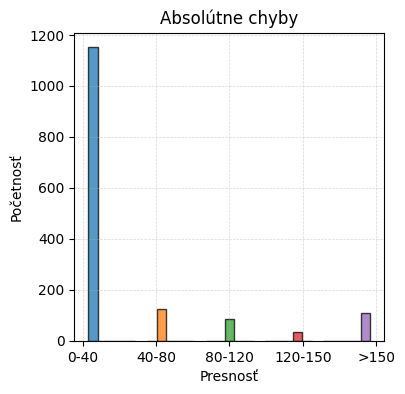

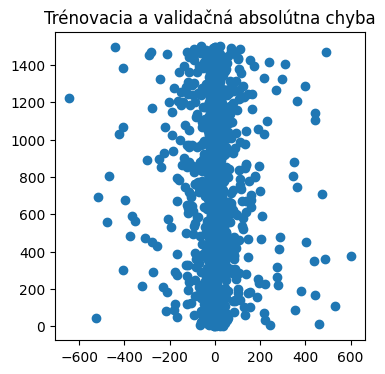

In [48]:
hist_percentage(test_y, test_predictions)
plot_true_predicted_difference(test_y, test_predictions)

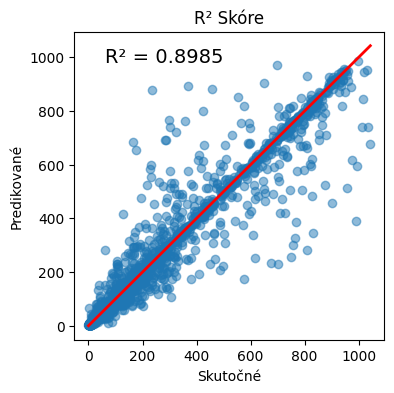

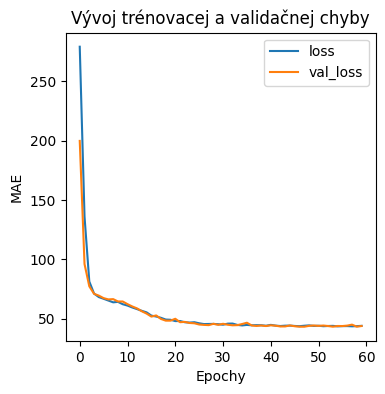

In [44]:
plot_r2(test_y, test_predictions)
plot_los_acc(hist)